# Analysis of evolution of influenza CTG codons in different host lineages

## Globals

In [1]:
import matplotlib
#matplotlib.use("svg")
from IPython.display import Image, display
import pylab ##?
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import re
import sys
import itertools
import math
import pyfaidx
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('font', size=9)
matplotlib.rc('xtick', labelsize=8)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=8)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=8)

from Bio.SeqUtils.CodonUsage import SynonymousCodons
matplotlib.rc('axes', linewidth=.6)
matplotlib.rc('xtick.major', width=.6)
matplotlib.rc('xtick.major', size=2.5)
matplotlib.rc('ytick.major', width=.6)

matplotlib.rc('ytick.major', size=2.5)


## Influenza CTG analysis

To examine signatures of selection against putative translation initiation at CTG codons in influenza, we first assembled five influenza sequence sets: human, classical swine, duck, chicken, and human H5N1 influenza. For these sequence sets we only include the protein coding sequences from segments that do not reassort in the human influenza lineage descended from the 1918 lineage: PB2, PA, NP, NS1, M1, M2, and NS2. We retained sequences for a strain if that strain has sequences for all genes in gene set. If there are multiple sequences for a given strain, we kept just one.


All human, H5N1, swine, avian protein coding sequences were downloaded from se- quences were downloaded from the Influenza Virus Resource. (http://www.ncbi.nlm.nih. gov/genomes/FLU/FLU.html).
For human influenza, we kept coding sequences descended from the 1918 virus, which includes H1N1 from 1918 to 1957, H2N2 from 1957 to 1968, and H3N2 from 1968 to 2011 [49]. Viruses from the 2009 swine-origin H1N1 pandemic are excluded. We subsampled our sequences so that we kept at most 5 strains per year, randomly chosen.
For human H5N1 influenza, we obtained sequences from 1997 to 2011, and did not subsample our sequences due to the low number of sequences.
For duck influenza, we obtained sequences from 1956 to 2011. We subsampled our duck influenza sequences so that we kept at most 5 strains per year, randomly chosen.
For chicken influenza, we obtained sequences from 1934 to 2011. We subsampled our chicken sequences so that we kept at most 5 strains per year, randomly chosen.
For swine influenza we selected classical swine H1N1 influenza viruses isolated in North America isolated between 1934 and 1998.


For alignment, and subsequent analysis we appended the seven protein coding regions (PB2, PA, NP, NS1, M1, M2, and NS2) together for each strain. Sequence sets are aligned to A/Brevig Mission/1/1918 virus using MUSCLE, with gaps relative to the A/Brevig Mission/1/1918 strain stripped away.


## Functions

In [2]:
def FindFile(filename, dirs):
    """Searches for a file in a set of directories.

    'filename' is a string giving a filename.
    'dirs' is a list of directories.
    Returns the file path to the file if it is found exactly once.
    If it is not found or found more than once, raises an Exception.
    """
    foundit = False
    for dir in dirs:
        #print "../data/influenzaseq/%s/%s" % (dir, filename)
        if os.path.isfile("../data/influenzaseq/%s/%s" % (dir, filename)):
            if foundit:
                raise IOError("Duplicate files: %s is also in %s" % (filename, dir))
            foundit = True
            #print 'yes'
            file = "../data/influenzaseq/%s/%s" % (dir, filename)
    if not foundit:
        raise IOError("Never found %s" % filename)
    else:
        return file


def MotifToRE(motif):
    """Returns an re object matching the nucleotide motif.
       'motif' is a string giving a nucleotide motif. It is converted
            to all caps. The following ambiguous nucleotide codes are enabled:
            R = A, G
            Y = C, T
            S = G, C
            W = A, T
            K = G, T
            M = A, C
            B = C, G, T
            D = A, G, T
            H = A, C, T
            V = A, C, G
            N = A, C, G, T
    """
    motif = motif.upper()
    d = {'A':'A',
         'T':'T',
         'C':'C',
         'G':'G',
         'R':'[AG]',
         'Y':'[CT]',
         'S':'[GC]',
         'W':'[AT]',
         'K':'[GT]',
         'M':'[AC]',
         'B':'[CGT]',
         'D':'[AGT]',
         'H':'[ACT]',
         'V':'[ACG]',
         'N':'[ACGT]'
        }
    m = re.compile(''.join([d[x] for x in motif]))
    return m


def MotifCounts(headseq, motif, frames, odds_or_counts):
    """Determines the counts or odds ratio of a motif in a sequence.

    'headseq' is 2-tuple (header, sequence).
    'motif' is a string specifying a sequence motif. It is 
        case insensitive, and the nucleotide codons can be specified
        using the IUPAC codes as detailed in MotifToRE.
    'frames' is a number or list giving the reading frames. Values
        are 1, 2, or 3. 1 corresponds to the standard reading frame, 
        2 and 3 are the first and second alternate frames. So setting
        this to [1, 2, 3] counts all occurrences of the motif.
    'odds_or_counts' specifies whether we are returning the absolute
        counts or the odds ratio. Allowable values are one of the
        two strings 'ODDS_RATIO' or 'COUNTS'. If it is 'COUNTS',
        the returned variable is simply the number of times that 
        motif occurs in the given frame(s). If it is 'ODDS_RATIO',
        the returned variable is the odds ratio. This is defined
        as the frequency of the motif in the given
        frame(s) divided by the product of the frequencies of
        the individual nucleotides in the motif in those reading
        frame(s). The ODDS_RATIO option returns None if
        one of the denominator frequencies is zero.
    Returns a number giving the counts or odds ratio.
    """
    assert isinstance(headseq, tuple) and len(headseq) == 2
    s = headseq[1] #.upper()
    motif_length = len(motif)
    m = MotifToRE(motif)
    assert isinstance(frames, list)
    for f in frames:
        if f not in [1, 2, 3]:
            raise ValueError("Invalid frame of %r" % f)
    frames = [{1:1, 2:2, 3:0}[f] for f in frames]
    if odds_or_counts == 'COUNTS':
        n = 0
        for i in range(len(s) - motif_length + 1):
            if (i + 1) % 3 in frames:
                if m.match(s[i : i + motif_length]):
                    n += 1
        return n
    elif odds_or_counts == 'ODDS_RATIO':
        n = nmotif = 0
        n_nt = [0 for i in range(motif_length)]
        m_nt = [MotifToRE(nt) for nt in motif]
        for i in range(len(s) - motif_length + 1):
            if (i + 1) % 3 in frames:
                n += 1
                substring = s[i : i + motif_length]
                if m.match(substring):
                    nmotif += 1
                for j in range(motif_length):
                    if m_nt[j].match(substring[j]):
                        n_nt[j] += 1
        if not n:
            return None
        f_motif = nmotif / float(n)
        f_nt = [x / float(n) for x in n_nt]
        denom = 1
        for x in f_nt:
            denom *= x
        if not denom:
            return None
        return f_motif / denom
    else:
        raise ValueError("Invalid value of odds_or_counts:\n%r" % odds_or_counts)


def PostMotifFrameLength(infile, motif, frames):
    """Determines the length of all reading frames following a motif.

    'infile' is the name of a FASTA file giving sequences. The headers for
        the sequences in this file must contain the year specified in
        the format " YEAR=2009 ", and this is used to parse out the year.
    'motif' and 'frames' have the same meaning as in 'MotifCounts'.
    The returned variable is a list of 2-tuples. The items in this
        2-tuple are (year, framelengths) where year is the year
        for that sequence and framelengths is a list of the length
        of all open reading frames initiated at the first nucleotide
        of motif. Reading frame lengths are returned in codons, and
        represent the number of amino acids in the open reading frame.
    """
    stop = ['TAA', 'TAG', 'TGA']
    yearmatch = re.compile('\sYEAR\=(\d{4})')
    m = MotifToRE(motif)
    motif_length = len(motif)
    assert isinstance(frames, list)
    for f in frames:
        if f not in [1, 2, 3]:
            raise ValueError("Invalid frame of %r" % f)
    frames = [{1:1, 2:2, 3:0}[f] for f in frames]
    motif_frames = []
    genes =  pyfaidx.Fasta(infile,read_long_names=True)
    #for (head, s) in pips.fasta.Read(infile):
    for s in genes:
        head=s.name
        #s=genes[entry].seq

        
        yearm = yearmatch.search(head)
        if not yearm:
            raise ValueError("Could not find YEAR in:\n%s" % head)
        year = int(yearm.group(1))
        s = str(s)
        framelengths = []
        for i in range(len(s) - motif_length + 1):
            if (i + 1) % 3 in frames:
                if m.match(s[i : i + motif_length]):
                    # i initiates a motif
                    ncodons = 0
                    codon = s[i : i + 3 + 3 * ncodons]
                    while (i + 3 + 3 * ncodons <= len(s)) and codon not in stop:
                        ncodons += 1
                        codon = s[i + 3 * ncodons : i + 3 + 3 * ncodons]
                    framelengths.append(ncodons)
        motif_frames.append((year, framelengths))
    return motif_frames



def MotifsByYear(infile, motif, frames, odds_or_counts):
    """Determines the frequencies of motifs for all sequences in a file.

    'infile' is the name of a FASTA file giving sequences. The headers for
        the sequences in this file must contain the year specified in
        the format " YEAR=2009 ", and this is used to parse out the year.
    'motif', 'frames', and 'odds_or_counts' have the same meaning as
        'MotifCounts'.
    The returned variable is a list of 2-tuples. The items in this
        2-tuple are (year, f) where year is the year for that sequence
        and f is the motif frequency as determined by 'MotifCounts'.
    """
    yearmatch = re.compile('\sYEAR\=(\d{4})')
    motif_freqs = []
    genes = pyfaidx.Fasta(infile,read_long_names=True)
    for seq in genes:
        head=seq.name

        m = yearmatch.search(head)
        if not m:
            raise ValueError("Could not find YEAR in:\n%s" % head)
        year = int(m.group(1))
        x = MotifCounts((head, str(seq)), motif, frames, odds_or_counts)
        motif_freqs.append((year, x))
        #break
    return motif_freqs





def PlotMotifsByYear(x_y_df_list,infiles, motif, frames, odds_or_counts):
    """Makes list of dataframes  for plotting motifs.

    'infiles' specifies the various data sets that we plot.
        It is a list of tuples: (file, sample)
        'file' is a FASTA file giving the sequences, with years readable
            as specified in MotifsByYear.
        'sample' is the name of the sample used in the plot legend.
    'motif', 'frames', and 'odds_or_counts' all have the meaning specified
        in 'MotifsByYear'.
        
    
    """
  
    x_y_list=[]

    for (infile, sample) in infiles:
        motif_freqs = MotifsByYear(infile, motif, frames, odds_or_counts)
        x = [tup[0] for tup in motif_freqs]
        y = [tup[1] for tup in motif_freqs]
    
        x_y_host_df=pd.DataFrame.from_items([('x',x),('y',y)])
        x_y_host_df['host']=sample
        x_y_host_df['motif']=motif

        x_y_list.append(x_y_host_df)
    x_y_df=pd.concat(x_y_list)
    x_y_df_list.append(x_y_df)


def PlotMotifsByYear_df(infiles, motif, frames, odds_or_counts, x_y_df_list):
    """Makes plots of the frequencies of motifs.

    'infiles' specifies the various data sets that we plot.
        It is a list of tuples: (file, sample)
        'file' is a FASTA file giving the sequences, with years readable
            as specified in MotifsByYear.
        'sample' is the name of the sample used in the plot legend.
    'motif', 'frames', and 'odds_or_counts' all have the meaning specified
        in 'MotifsByYear'.
    'title' is a string with the title given to the plot.
    'showlegend' is a Boolean switch specifying whether we show the legend.
    'figsize' is a 2-tuple giving the width and height in inches.
    'showplot' is a Boolean switch specifying whether we display the 
        plot on the screen.
    'savefig' is None by default. If it is set to a file name, then
        the figure is saved to that file name provided that the
        extension is a valid output file format.
    Various other plot formatting parameters are hard-coded at the 
        beginning of this function.
    """
  
    i = 0
    x_y_list=[]
    ymin = ymax = None

    for (infile, sample) in infiles:
        motif_freqs = MotifsByYear(infile, motif, frames, odds_or_counts)
        x = [tup[0] for tup in motif_freqs]
        y = [tup[1] for tup in motif_freqs]
        if ymin == None:
            ymin = min(y)
            ymax = max(y)
        else:
            ymin = min(ymin, min(y))
            ymax = max(ymax, max(y))
        x_y_host_df=pd.DataFrame.from_items([('x',x),('y',y)])
        x_y_host_df['host']=sample
   
        x_y_host_df['Reading frame']=frames[0]

        x_y_list.append(x_y_host_df)
    x_y_df=pd.concat(x_y_list)
    x_y_df_list.append(x_y_df)
    

## Fig 1a and 1b Plot number of CTG/CTH codons and CTGG and CTGH in reading frame (RF) 0 of influenza genome

We begin by looking at how the number of the indicated motif in reading frame 0 of the influenza sequence sets defined above for the seven protein coding regions (PB2, PA, NP, NS1, M1, M2, and NS2)







/fh/fast/bloom_j/software/conda/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:232: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


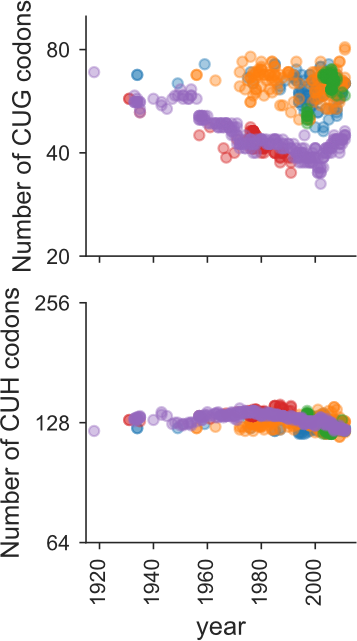

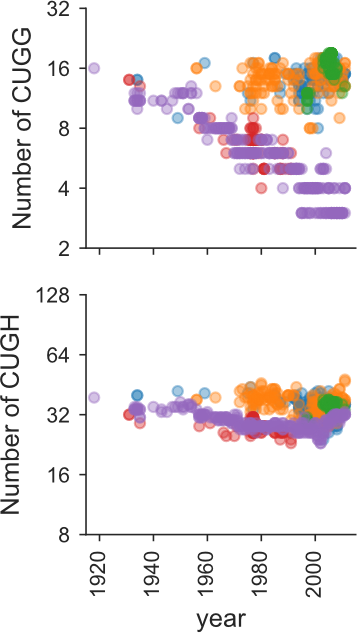

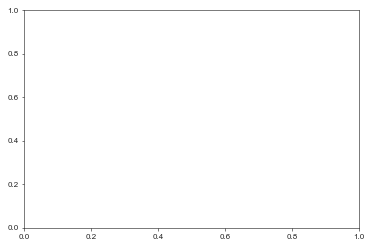

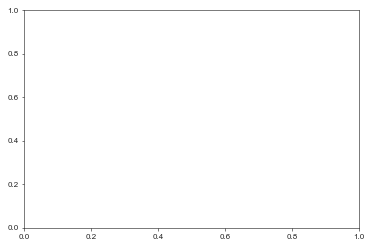

In [3]:

# Begin analysis by looping through  codon motif and reading frames
# and finding the largest differences between distributions of motifs.
dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [ 'chicken', 'duck','humanH5N1','swine','human'] # host/viruses

host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
genes = ['concatenated'] # genes to analyze for average motifs

codons = [['CTG','CTH'],['CTGG','CTGH']]
frames = [[1]] # each of the three reading frames
plotdir = '../figures/' # directory to save plots
year_range = (1970, 2011) # year range for motif average comparison
yaxis=[]
legendplotted=False
for frame in frames:
    j=0
    for motifset in codons:
        x_y_df_list=[]
        for motif in motifset:
  
            if len(frame) == 1:
                description = 'motif %s in reading frame %d' % (motif, frame[0])
            else:
                description = 'motif %s in reading frames %s and %d' % (motif, ', '.join([str(x) for x in frame[ : -1]]), frame[-1])
            for gene in genes:
                counts_list = []
                odds_list = []
                infiles = []
                for host in hosts:
                    file = FindFile('%s_%s.fasta' % (host, gene), dirs)
                    infiles.append((file, host_names[host]))
                    counts_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'COUNTS') if year_range[0] <= tup[0] <= year_range[1]])
                    odds_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'ODDS_RATIO') if year_range[0] <= tup[0] <= year_range[1]])

                for odds_or_counts in ['COUNTS']:
                    plotfile = '%s/%s-frame%s-gene_%s-%s.svg' % (plotdir, motif, '+'.join([str(x) for x in frame]), gene, odds_or_counts.lower())
                    PlotMotifsByYear(x_y_df_list,infiles, motif, frame, odds_or_counts) 
        x_y_df_concat=pd.concat(x_y_df_list) 
        fig, ax = matplotlib.pyplot.subplots()
        g = sns.FacetGrid(x_y_df_concat, row="motif", hue="host",sharey=False)
        g = (g.map(plt.scatter, "x", 'y', marker="o",alpha=.4,s=15).set_titles("").set(xlim=(1915,2015),xticks=[1920,1940,1960,1980,2000]).set_xlabels('year'))
        if j==0:
            g.axes[0,0].set_ylabel('Number of %s codons'%motifset[0].replace('T','U'))
            g.axes[1,0].set_ylabel('Number of %s codons'%motifset[1].replace('T','U'))
            #g.axes.set_yscale('log', basey=2)

            g.axes[0,0].set_ylim([16,80])
            g.axes[1,0].set_ylim([64,256])
            
            g.axes[0,0].set_yscale('log', basey=2)
            g.axes[1,0].set_yscale('log', basey=2)
         
            g.axes[0,0].set_yticklabels([10,20,40,80]) #set_xticklabels(labels)
            g.axes[1,0].set_yticklabels([32,64,128,256])


        else:
            g.axes[0,0].set_ylabel('Number of %s'%motifset[0].replace('T','U'))
            g.axes[1,0].set_ylabel('Number of %s'%motifset[1].replace('T','U'))
         
            g.axes[0,0].set_ylim([2,32])
            #g.axes[0,0].set_yticklabels([2,4,8,16,32]) #set_xticklabels(labels)
            g.axes[1,0].set_ylim([8,128])
            g.axes[0,0].set_yscale('log', basey=2)
            g.axes[1,0].set_yscale('log', basey=2)

            g.axes[0,0].set_yticklabels([0,2,4,8,16,32]) #set_xticklabels(labels)
            g.axes[1,0].set_yticklabels([4,8,16,32,64,128])

            
        j+=1
        plt.xticks(rotation=90)
        g.fig.set_size_inches([2.2, 3.6])
        g.fig.tight_layout() 
        # Put a legend to the right side
        savefilename='../figures/RF1_%s_%s_counts.svg'%(motifset[0],motifset[1])
        plt.savefig(savefilename)
        png = savefilename.rstrip('.svg') + '.png'
        !convert -density 192 -trim $savefilename $png
        display(Image(png, width=200))
        plt.close()

        sys.stdout.flush()


## SFig1 CTG OR and count is plotted for each RF

Motif odds ratio is defined in Greenbaum et al Plos Pathogens 2008 and accouns for the underlying nucleotide content of a sequence

/fh/fast/bloom_j/software/conda/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:277: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


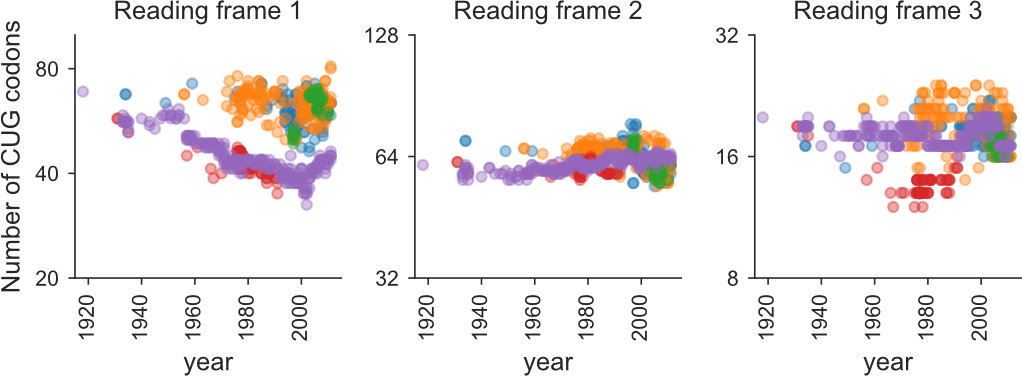

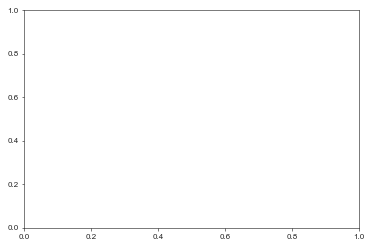

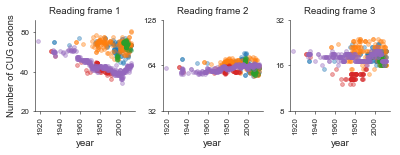

In [4]:
frames = [[1],[2],[3]] # each of the three reading frames
dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [  'chicken', 'duck','humanH5N1','swine','human'] # host/viruses
host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
genes = ['concatenated'] # genes to analyze for average motifs
codons = ['CTG']
plotdir = '../figures/' # directory to save plots

year_range = (1970, 2011) # year range for motif average comparison
x_y_df_list=[]

for motif in codons:
    for frame in frames:
        if len(frame) == 1:
            description = 'motif %s in reading frame %d' % (motif, frame[0])
        else:
            description = 'motif %s in reading frames %s and %d' % (motif, ', '.join([str(x) for x in frame[ : -1]]), frame[-1])
        for gene in genes:
            counts_list = []
            odds_list = []
            infiles = []
            for host in hosts:
                file = FindFile('%s_%s.fasta' % (host, gene), dirs)
                infiles.append((file, host_names[host]))
                counts_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'COUNTS') if year_range[0] <= tup[0] <= year_range[1]])
                odds_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'ODDS_RATIO') if year_range[0] <= tup[0] <= year_range[1]])

            for odds_or_counts in ['COUNTS']:
            
                PlotMotifsByYear_df(infiles, motif, frame, odds_or_counts, x_y_df_list)
    
plotfile = '%s/%s-gene_%s-%s.svg' % (plotdir, motif, gene, odds_or_counts.lower())
x_y_df_concat=pd.concat(x_y_df_list) 

fig, ax = matplotlib.pyplot.subplots()
g = sns.FacetGrid(x_y_df_concat, col="Reading frame", hue="host",sharey=False)
g = (g.map(plt.scatter, "x", 'y', marker="o",alpha=0.4,s=15).set_titles("Reading frame {col_name}").set_ylabels('Number of CUG codons').set(xlim=(1915,2015),xticks=[1920,1940,1960,1980,2000]).set_xlabels('year'))

yaxis=[[16,80],[32,128],[8,32]]
yticklab=[[10,20,40,80],[16,32,64,128],[4,8,16,32]]
j=0

for ax in g.axes.ravel():
    #for ax in axlist:
    ax.set_ylim(yaxis[j])
    ax.set_yscale('log', basey=2)
    ax.set_yticklabels(yticklab[j])
    j+=1
    
g.set_xticklabels(rotation=90)
plt.xlim(1915,2015)

g.set_xticklabels([1920,1940,1960,1980,2000])
g.fig.set_size_inches([5.5, 2.1])
g.fig.tight_layout(pad=.5) 
plt.savefig(plotfile)

png = plotfile.rstrip('.svg') + '.png'
!convert -density 192 -trim $plotfile $png
display(Image(png, width=400))

sys.stdout.flush()

/fh/fast/bloom_j/software/conda/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:277: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


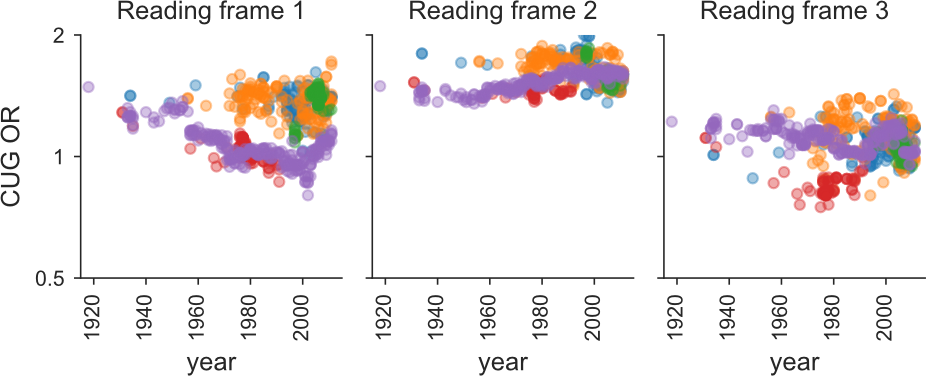

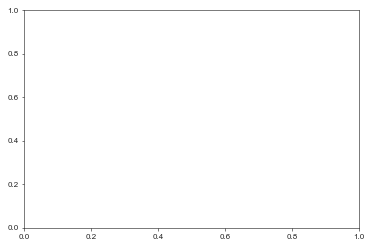

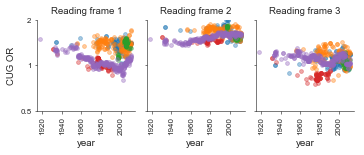

In [5]:
frames = [[1],[2],[3]] # each of the three reading frames
dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [  'chicken', 'duck','humanH5N1','swine','human'] # host/viruses
host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
genes = ['concatenated'] # genes to analyze for average motifs
codons = ['CTG']
plotdir = '../figures/' # directory to save plots
year_range = (1970, 2011) # year range for motif average comparison
x_y_df_list=[]

for motif in codons:
    for frame in frames:
        if len(frame) == 1:
            description = 'motif %s in reading frame %d' % (motif, frame[0])
        else:
            description = 'motif %s in reading frames %s and %d' % (motif, ', '.join([str(x) for x in frame[ : -1]]), frame[-1])
        for gene in genes:
            counts_list = []
            odds_list = []
            infiles = []
            for host in hosts:
                file = FindFile('%s_%s.fasta' % (host, gene), dirs)
                infiles.append((file, host_names[host]))
                counts_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'COUNTS') if year_range[0] <= tup[0] <= year_range[1]])
                odds_list.append([tup[1] for tup in MotifsByYear(file, motif, frame, 'ODDS_RATIO') if year_range[0] <= tup[0] <= year_range[1]])

            for odds_or_counts in ['ODDS_RATIO']:
       
                PlotMotifsByYear_df(infiles, motif, frame, odds_or_counts, x_y_df_list)
    
plotfile = '%s/%s-gene_%s-%s.svg' % (plotdir, motif, gene, odds_or_counts.lower())
x_y_df_concat=pd.concat(x_y_df_list) 

fig, ax = matplotlib.pyplot.subplots()
g = sns.FacetGrid(x_y_df_concat, col="Reading frame", hue="host")
g = (g.map(plt.scatter, "x", 'y', marker="o",alpha=.4,s=15).set_titles("Reading frame {col_name}").set_ylabels('CUG OR').set(xlim=(1915,2015),xticks=[1920,1940,1960,1980,2000]).set_xlabels('year'))
j=0
for ax in g.axes.ravel():

    ax.set_ylim(.5,2)

    ax.set_yscale('log', basey=2)
    ax.set_yticklabels([0.25,0.5,1,2])

g.set_xticklabels(rotation=90)
plt.xlim(1915,2015)

g.set_xticklabels([1920,1940,1960,1980,2000])
g.fig.set_size_inches([5., 2.1])
g.fig.tight_layout(pad=.5) 

plt.savefig(plotfile)
png = plotfile.rstrip('.svg') + '.png'
!convert -density 192 -trim $plotfile $png
display(Image(png, width=400))

sys.stdout.flush()

## F1c Distribution of open reading frame lengths (reading frames 1 and 2) in host adapted influenza genomes.

For the non-canonical reading frames 2 and 3 of influenza we also examined selection against putative CTG initiation by examining whether there was a host specific difference in putative ORF lengths (Fig. 7C). We selected a timeframe where the human and swine influenza strains should be relatively host adapted (1970 to 2011), and took sequences for the human, duck, chicken, swine, H5N1 sequence sets from that time. We calculated the length of all putative ORFs initiated by CTG or for CTH (where H is A, T or C) for reading frames 2 and 3 for each influenza sequence set. To plot the data, we took all of the ORF lengths and divided them into 5 ORF length bins. For each influenza host sequence set, we calculated the average number of ORFs for that bin by dividing the number of ORFs in that bin by the number of influenza strains for that host.

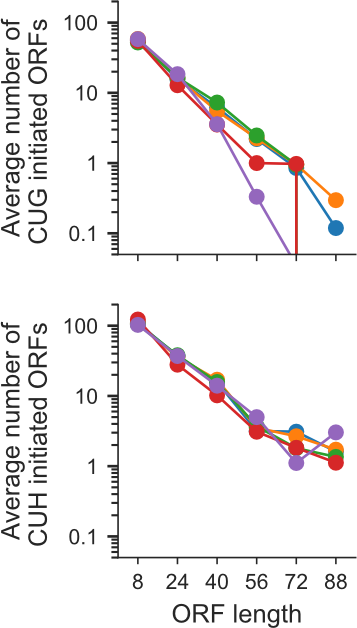

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

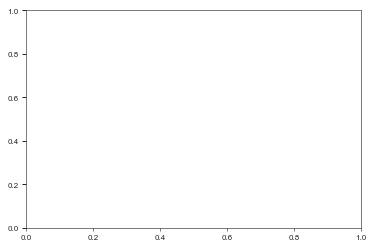

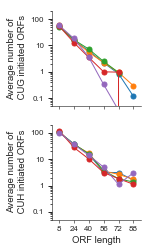

In [6]:
matplotlib.rc('ytick.major', width=1)

matplotlib.rc('ytick.major', size=4)
matplotlib.rc('ytick.minor', size=2.5)

# Now look at the lengths of the reading frames after the CTG motifs in frames 2 and 3
dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [  'chicken', 'duck','humanH5N1','swine','human'] # host/viruses plot order

host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
genes = ['concatenated'] # genes to analyze for average motifs
motifs = ['CTG','CTH']
gene = 'concatenated'
year_range = (1970, 2011) # year range for motif average comparison
frames = [2, 3]

def PlotMotifORFLengthDistribution(length_data,host,infiles, motif, frames, ylabel, year_range):
    """Plots distribution of length of ORFs initiated by a motif.
    
    'infiles', 'motif', 'frames', 'showlegend', 'figsize', 'showplot',
        and 'savefig' all have the same meaning as in PlotMotifsByYear.
    'ylabel' is the y-axis label.
    'year_range' is a 2-tuple of the form (startyear, endyear). We only
        include sequences from years that fall within this range:
        staryear <= year <= endyear
    """
    bins = [0, 16, 32, 48, 64, 80, 96]

    i = 0
    fig = pylab.figure()
    samples = [] # names of samples
    orflengths = [] # list of lists of lengths
    weights = []
    plotting_df_list=[]
    for (infile, sample) in infiles:
        #print sample,host
        samples.append(sample)
        sample_orflengths = []
        n = 0
        for (year, framelengths) in PostMotifFrameLength(infile, motif, frames):
            if year_range[0] <= year <= year_range[1]:
                sample_orflengths += framelengths
                n += 1
        adjusted = []
        for l in sample_orflengths:
            if l > bins[-1]:
                adjusted.append(bins[-1] - 0.0000001)
                #print "Length of %d for %s being adjusted down to %d." % (max(sample_orflengths), sample, bins[-1])
            else:
                adjusted.append(l)
        sample_orflengths = adjusted
        counts,binsnp = np.histogram(sample_orflengths, bins=bins)
        count_adj=[float(c)/n for c in counts]

        average_length_dict={'ORF length': [8, 24, 40, 56, 72, 88], 'host': [sample]*len(count_adj),'length':count_adj}
        average_length_df=pd.DataFrame(data=average_length_dict)
        plotting_df_list.append(average_length_df)
        
    x_y_df_concat=pd.concat(plotting_df_list) 
    x_y_df_concat['motif']=motif
    length_data.append(x_y_df_concat)
frames = [2, 3]
infiles = [(FindFile('%s_%s.fasta' % (host, gene), dirs), host_names[host]) for host in hosts]
showlegend = True
lengthdata=[]
for motif in motifs:
    
    ylabel = "average number of\n%s initiated ORFs" % motif
    filename = '%s/Alternative-%s_initiated_ORFS.svg' % (plotdir, motif)
    findlengths=PlotMotifORFLengthDistribution(lengthdata,host,infiles, motif, frames, ylabel, year_range=year_range)
    
lengthdata_concat=pd.concat(lengthdata)
fig, ax = matplotlib.pyplot.subplots()
d={"linewidth" : [1,1,1,1,1],'alpha':[1,1,1,1,1]}
g = sns.FacetGrid(lengthdata_concat, row="motif", hue="host",hue_kws=d)
g = (g.map(plt.plot, "ORF length", 'length', alpha=1,marker=".",markersize=10).set_titles("").set(xlim=(0,96),xticks=[8, 24, 40, 56, 72, 88])) #.set_xlabels('year'))
g.axes[0,0].set_ylabel("Average number of\n %s initiated ORFs"%motifs[0].replace('T','U'))
g.axes[1,0].set_ylabel("Average number of\n %s initiated ORFs"%motifs[1].replace('T','U'))
plt.yscale('log')
plt.ylim(.05,200)
for ax in g.axes.ravel():
    ax.set_yticklabels([0.001,0.01,0.1,1,10,100])
    
g.fig.set_size_inches([2.2, 3.6])
g.fig.tight_layout() 


    # Put a legend to the right side
#g.fig.legend(loc='center right') #, bbox_to_anchor=(1.5, 0.5), ncol=1)
    
sns.despine()
savefilename='../figures/average_orf_length_frame_2_3_%s.svg' %motif
plt.savefig(savefilename)
png = savefilename.rstrip('.svg') + '.png'
!convert -density 192 -trim $savefilename $png
display(Image(png, width=200))

sys.stdout.flush()

## SFig2 Plot the number of synonymous LEU, VAL, ILE codons over time in reading frame 0

/fh/fast/bloom_j/software/conda/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


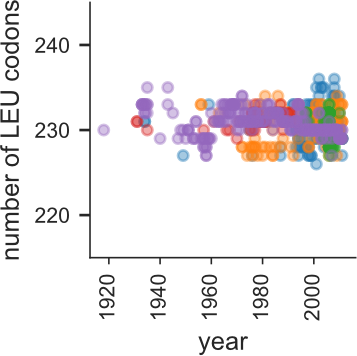

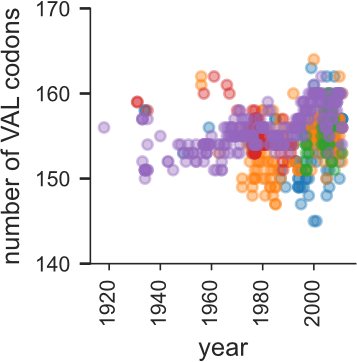

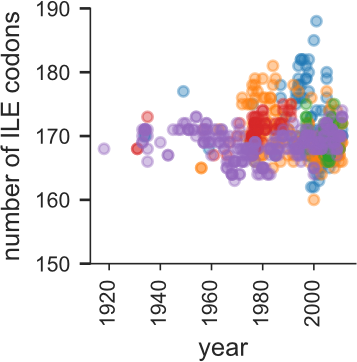

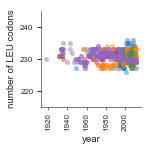

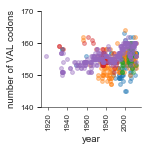

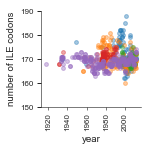

In [7]:

dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [  'chicken', 'duck','humanH5N1','swine','human'] # host/viruses

host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
gene = 'concatenated'
frame = [1] # each of the three reading frames
odds_or_counts='COUNTS'
aminoacids=["LEU","VAL","ILE"]
infiles = [(FindFile('%s_%s.fasta' % (host, gene), dirs), host_names[host]) for host in hosts]
ylim=[[215,245],[140,170],[150,190]]
j=0
for aminoacid in aminoacids:
    x_y_list=[]
    for [infile,sample] in infiles:
        yearmatch = re.compile('\sYEAR\=(\d{4})')
        motif_freqs = []
        genes = pyfaidx.Fasta(infile,read_long_names=True)
        for seq in genes:
            head=seq.name
            m = yearmatch.search(head)
            if not m:
                raise ValueError("Could not find YEAR in:\n%s" % head)
            year = int(m.group(1))
            x_tot=0
            for motif in SynonymousCodons[aminoacid]:
                x = MotifCounts((head, str(seq)), motif, frame, odds_or_counts)
                x_tot+=x
            motif_freqs.append((year, x_tot))
        x = [tup[0] for tup in motif_freqs]
        y = [tup[1] for tup in motif_freqs]
    
        x_y_host_df=pd.DataFrame.from_items([('x',x),('y',y)])
        x_y_host_df['host']=sample
   
        x_y_host_df['Reading frame']=frame[0]

        x_y_list.append(x_y_host_df)
    x_y_df=pd.concat(x_y_list)
    
    
    g=sns.lmplot('x', # Horizontal axis
           'y', # Vertical axis
           data=x_y_df, # Data source
           legend=False,
           fit_reg=False, # Don't fix a regression line
           hue="host", # Set color
           markers='o',
           scatter_kws={ "s": 15,'alpha':.4})
    g = (g.set_axis_labels("year", {'COUNTS':'number of %s codons' % aminoacid, 'ODDS_RATIO':'%s odds ratio' %motif}[odds_or_counts]).set(xticks=[1920,1940,1960,1980,2000],ylim=ylim[j]))
    plt.xticks(rotation=90)
   
    g.fig.set_size_inches([2.2, 2.2])
    #g.fig.legend(loc='center right') #, bbox_to_anchor=(1.5, 0.5), ncol=1)
    g.fig.tight_layout() 
    j+=1
  
    savefilename='../figures/%s_RF_1_counts.svg'% aminoacid
    plt.savefig(savefilename)
    png = savefilename.rstrip('.svg') + '.png'
    !convert -density 192 -trim $savefilename $png
    display(Image(png, width=200))

    sys.stdout.flush()


## SFig3 Make logoplots of consensus motif for CTG start sites contained in Ingolia et al 2011 (supplemental file 3 )

In [8]:
%%bash

sed -i 's/T/U/g' ../data/ingolia/CTG_contexts.fasta

sed: can't read ../data/ingolia/CTG_contexts.fasta: No such file or directory


In [9]:
%%bash

weblogo  --fineprint ''  --fontsize 9 --title-fontsize 9 --number-fontsize 7 --yaxis .2 -s medium  -c classic --errorbars false --title 'CUG start sites from Ingolia et al' --rotate-numbers true --annotate '-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10' <../data/ingolia/CTG_contexts.fasta> ../figures/ingolia_CTG_contexts_weblogo.eps

bash: line 2: ../data/ingolia/CTG_contexts.fasta: No such file or directory


## Plot distributions of codon over time for all codons
Read codon counts into data frame:

In [10]:
dirs = ['avian', 'human', 'swine',  'humanH5N1'] # directories to look for files
hosts = [ 'chicken', 'duck','humanH5N1','swine','human'] # host/viruses

host_names = {'human':'human', 'swine':'swine', 'humanH5N1':'H5N1', 'chicken':'chicken', 'duck':'duck'}
genes = ['concatenated'] # genes to analyze for average motifs

codons = list(''.join(tup) for tup in itertools.product('ACGT', 'ACGT', 'ACGT') 
              if ''.join(tup) not in ['TAA', 'TGA', 'TAG'])
plotdir = '../figures/' # directory to save plots
year_range = (1970, 2011) # year range for motif average comparison
yaxis=[]
legendplotted=False

df_list = []
for host in hosts:
    infile = FindFile('%s_%s.fasta' % (host, 'concatenated'), dirs)
    for codon in codons:
        df_i = (pd.DataFrame.from_records(
                    MotifsByYear(infile, codon, frames=[1], odds_or_counts='COUNTS'),
                    columns=['year', 'count']
                    )
                .assign(gene=gene, host=host, codon=codon)
                )
        df_list.append(df_i)
df = pd.concat(df_list)

Get codons with largest change in across all hosts:

In [11]:
change = (
      df
      .assign(mincount=lambda x: x['count'],
              maxcount=lambda x: x['count'])
      .groupby('codon')
      .aggregate({'mincount':'min', 'maxcount':'max'})
      .reset_index()
      .assign(abs_change=lambda x: x.maxcount - x.mincount,
              fold_change=lambda x: x.mincount / x.maxcount,
              label=lambda x: x.codon + ' ($\Delta$ = ' +
                              x.abs_change.astype('str') + ' = ' + 
                              x.maxcount.astype('str') +
                              ' - ' + x.mincount.astype('str') + ')')
      .sort_values('abs_change', ascending=False)
      .reset_index(drop=True)
      .reset_index()
      .rename(columns={'index':'icodon'})
      )

Add changes into original data frame:

In [12]:
df = df.merge(change)

Make plot:

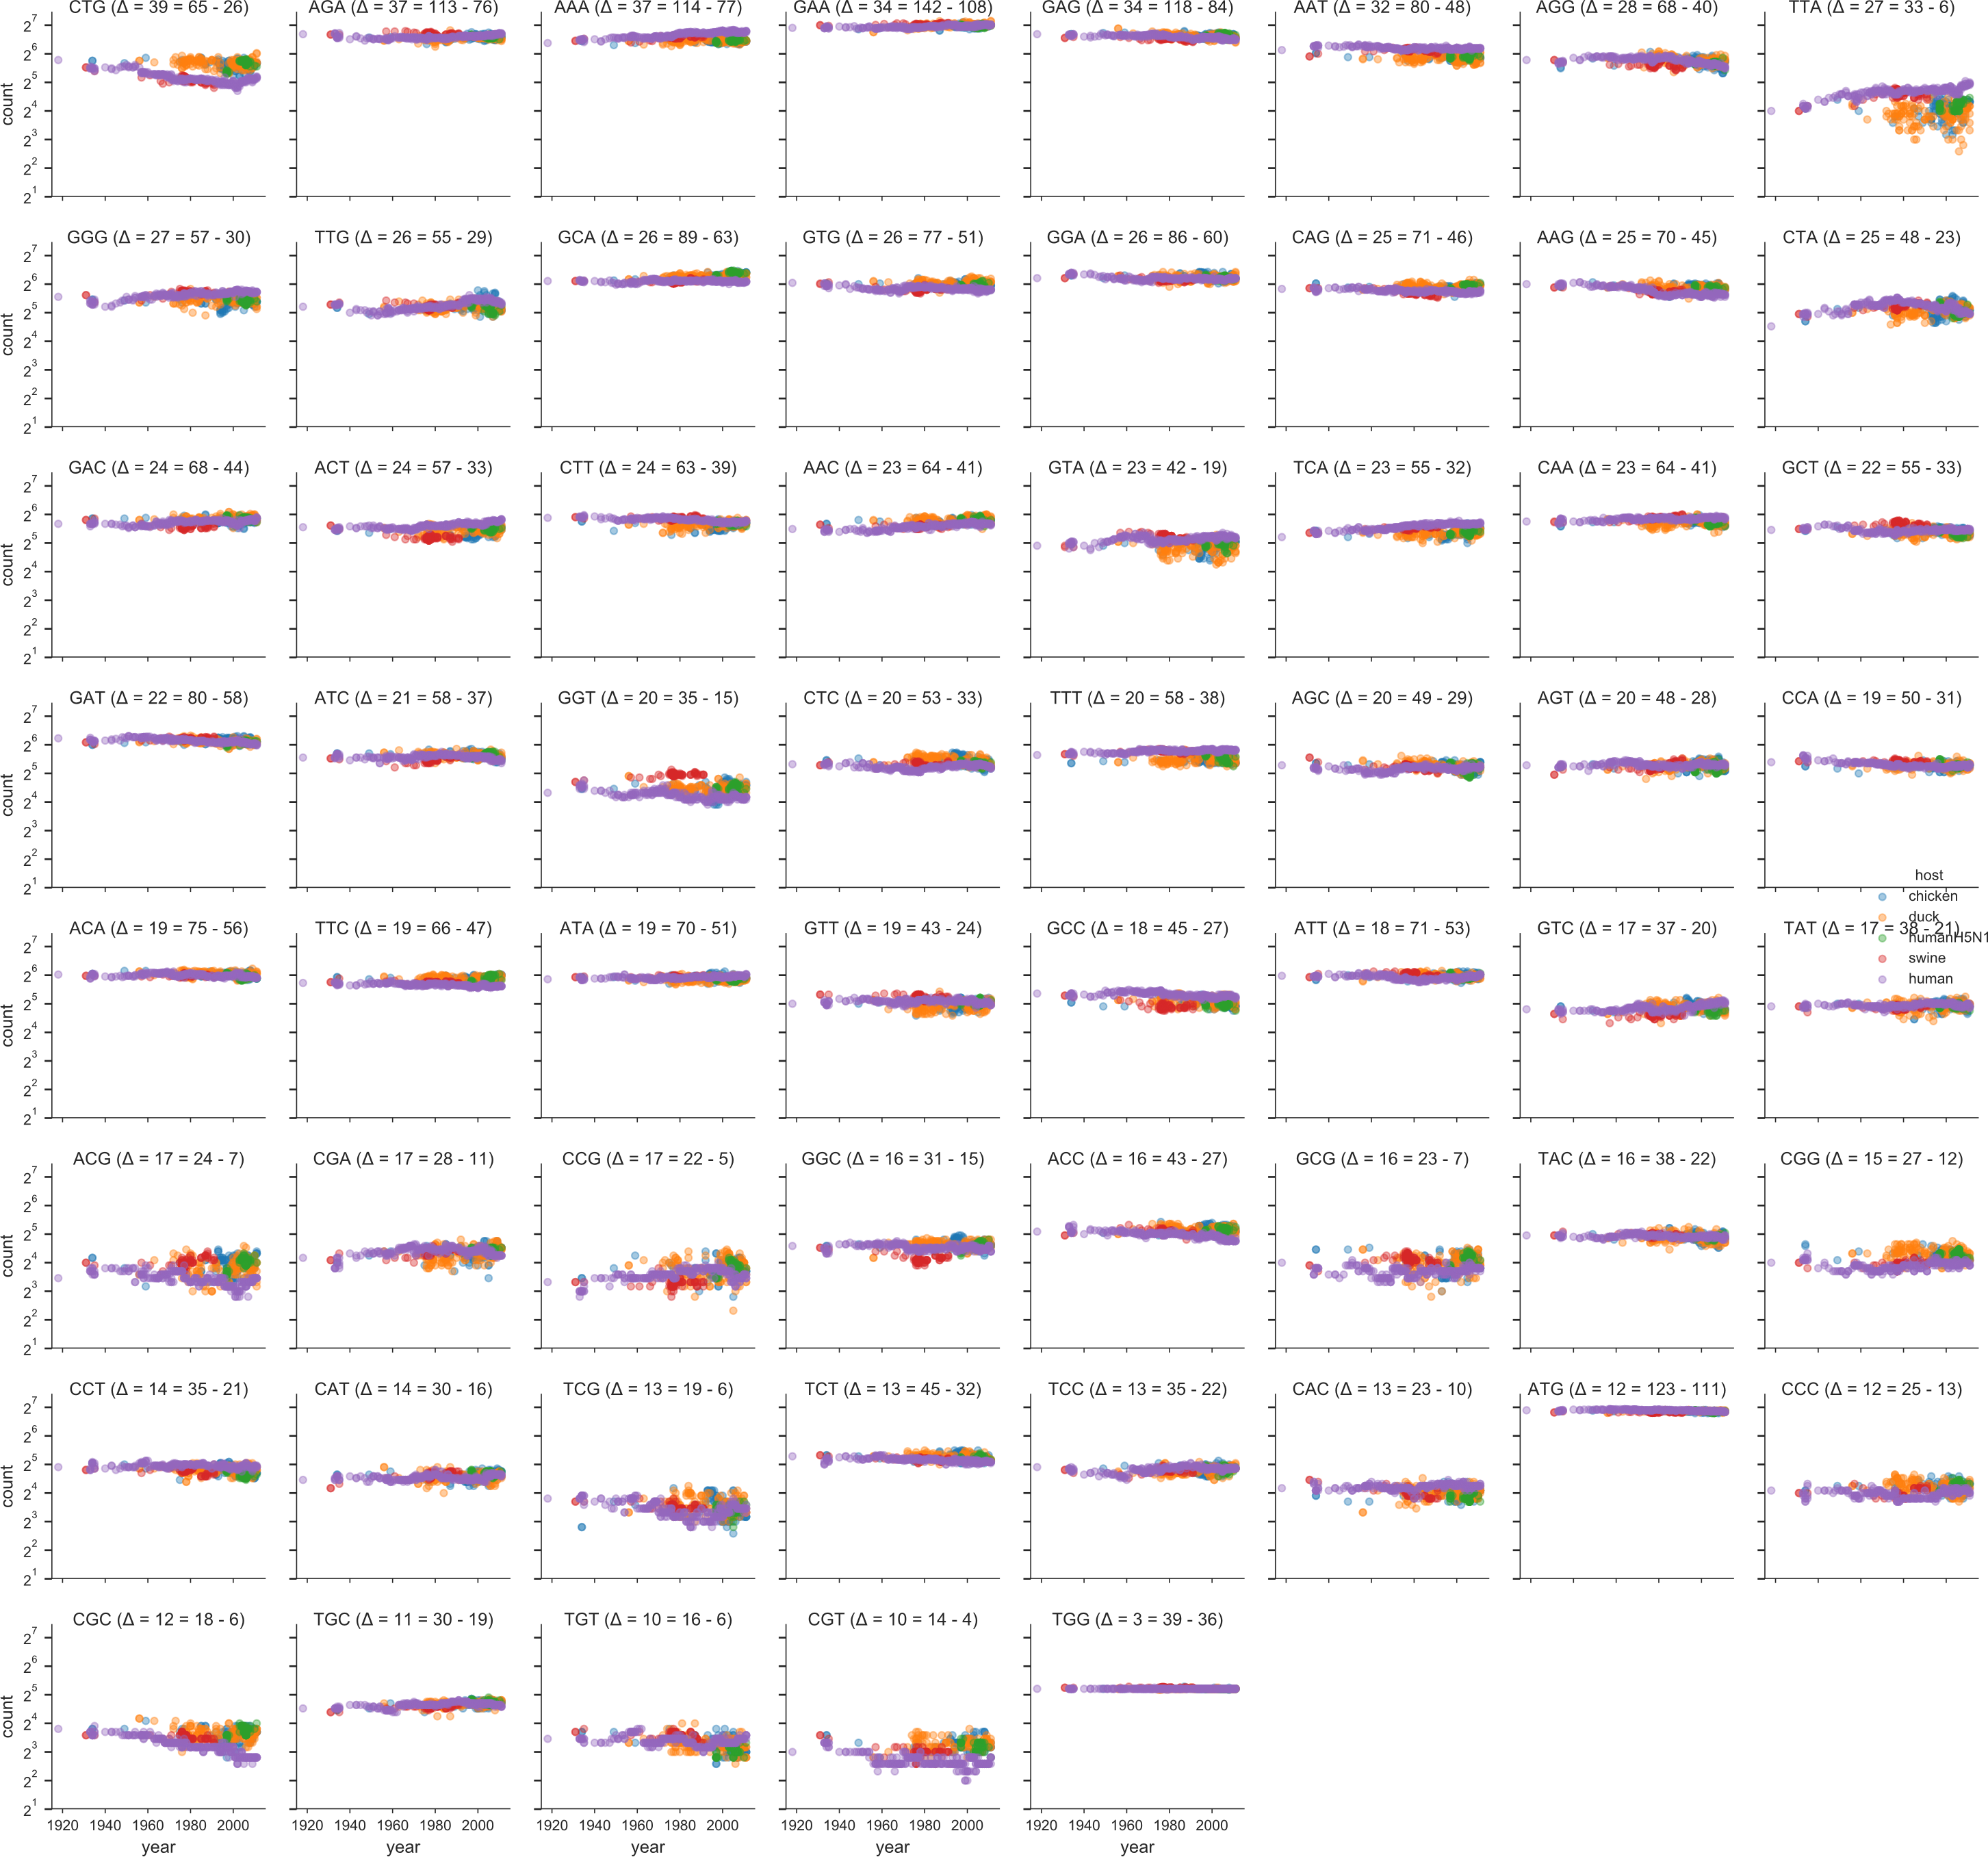

In [13]:
ncols = 8
g = sns.FacetGrid(df.assign(row=lambda x: x.icodon // ncols,
                            col=lambda x: x.icodon % ncols),
                  row="row", col='col', hue="host", legend_out=True)

g = (g.map(plt.scatter, "year", 'count', marker="o", alpha=.4, s=15)
           .set_titles("")
           .set(xlim=(1915, 2015), xticks=[1920, 1940, 1960, 1980, 2000])
           .set_xlabels('year')
           )
for ax, label in zip(g.axes.flatten(), change.label):
    ax.set_title(label, verticalalignment='top')
    ax.set_yscale('log', basey=2)
    
# hide empty grids: https://stackoverflow.com/a/41306194
for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()

facetsize = 1.8
g.fig.set_size_inches([facetsize * ncols, facetsize * math.ceil(len(codons) / ncols)])
g.add_legend()
g.fig.tight_layout()

savefilename='../figures/all_codon_counts.svg'
plt.savefig(savefilename)
plt.savefig(os.path.splitext(savefilename)[0] + '.pdf')
png = savefilename.rstrip('.svg') + '.png'
!convert -density 192 -trim $savefilename $png
display(Image(png))
plt.close()